# Symulowane wyżarzanie

In [13]:
%matplotlib inline
import numpy as np
import math
from copy import copy, deepcopy
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.animation as animation
from IPython.display import HTML
from functools import reduce
animation.writers.list()

['pillow', 'ffmpeg', 'ffmpeg_file', 'imagemagick', 'imagemagick_file', 'html']

Na początku definiujemy funkcję przeprowadzającą proces symulowanego wyżarzania. Jest ona rozbudowana ponieważ jest używana dla wszystkich zadań dla wszyskich zadań. Taka uniwersalność jest mocną stroną tej metody. Przyjmuje ona aktualny stan, funkcję liczącą energię, funkcję wykonującą tuch oraz dodatkowe parametry takie jak:  
- s_p - prawdopodobieństwo początkowe, dla przejścia w stan wyższej energii
- p - krok o jaki zmienia się prawdopodobiństwo (cp = s_p * p^i)
- iters - maksymalna liczba iteracji  

Dodatkowo definiujemy dwie możliwości wykonania ruchu. Pierwsza polega na stworzeniu kopii tablicy przed ruchem i ewentualnym odtworzeniu jej później. Druga natomiast bazuje na tym, że funkcje wykonujące ruch mogą być odwracalne (funkcja step_back), jeśli zdefiniujemy taką funkcję to możemy pominąć proces kopiowania całej tablicy, np. jeśli zamieniamy ze sobą tylko dwie liczby, co może wpłynąc na wydajność tej metody. 

In [305]:
def simulated_annealing(T, E, step, step_back = None, s_p = 0.3, p = 0.9999, iters = 10000, anim_step = None, debug_step = None):
    i = 0
    i_x = []
    i_y = []
    cT = deepcopy(T)
    anim = []
    cp = s_p
    best = deepcopy(T)
    Eb = E(best)
    equals = 0
    while i < iters and equals < 5000:
        if step_back == None:
            to_restore = deepcopy(cT)
        
        Ep = E(cT)
        step_prop = step(cT)
        En = E(cT)
        if En > Ep and random.random() > cp:
            if step_back == None:
                cT = to_restore
            else:
                step_back(cT, *step_prop) 
                En = Ep
        
        if Eb > En:
            best = deepcopy(cT)
            Eb = En
        
        if Ep == En:
            equals += 1
        else:
            equals = 0
        
        i_x.append(i)
        i_y.append(E(cT))
        
        if anim_step != None and i % anim_step == 0:
            anim.append(deepcopy(cT))
        
        if debug_step != None and i % debug_step == 0:
            print("SA step ", i)
        
        cp *= p
        i += 1
    return best, i_x, i_y, anim

# TSP

Na początek zajmujemy się problemem komiwojażera. Definiujemy funkcje pomocnicze do tworzenia i wyświetlania mapy.

In [404]:
def generate_random_points(n, a = 100):
    return [(random.random()*a, random.random()*a) for i in range(n)]

In [405]:
def show(points):
    x = list(map(lambda x: x[0], points))
    y = list(map(lambda x: x[1], points))
    plt.plot(x, y)
    plt.show()

In [406]:
def dist(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

Funkcja energii dla tego problemu jest zdefiniowana jako suma odległości pomiędzy kolejnymi miastami na trasie.

In [407]:
def E(points):
    E = 0
    for i in range(len(points)):
        E += dist(points[i], points[(i+1)%len(points)])
    return E

Definiujemy również dwie metody wykonywania zamiany. Pierwsza z nich zamienia ze sobą dowolne dwa miasta na trasie, druga natomiast tylko dwa sąsiednie. Definiujemy dla nich również funckję odwracającą ruch.

In [408]:
def make_swap(points):
    i = random.randint(0, len(points)-1)
    j = random.randint(0, len(points)-1)
    points[i], points[j] = points[j], points[i]
    return i, j

In [409]:
def make_swap_neigh(points):
    i = random.randint(0, len(points)-2)
    points[i], points[i+1] = points[i+1], points[i]
    return i, i + 1

In [410]:
def make_back_swap(points, i, j):
    points[i], points[j] = points[j], points[i]

In [438]:
def TSP(points, swap = make_swap):
    show(points)
    points, i_x, i_y, _ = simulated_annealing(points, E, swap, make_back_swap, p = 0.9998, iters=50000)
    show(points)
    return i_x, i_y

Porównujemy działanie obu zamian. Tworzymy także wykres zmiany energii dla kolejnych kroków algorytmu.

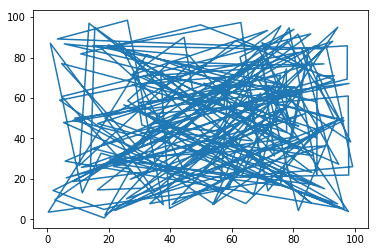

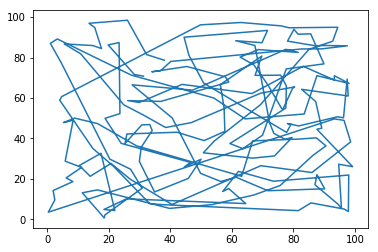

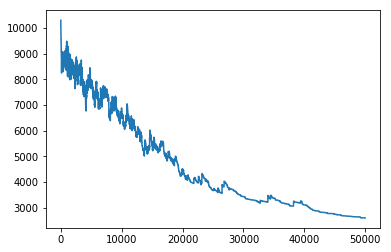

In [439]:
N = 200
points = generate_random_points(N, 100)
cpoints = copy(points)

i_x, i_y = TSP(points)
plt.plot(i_x, i_y)
plt.show()

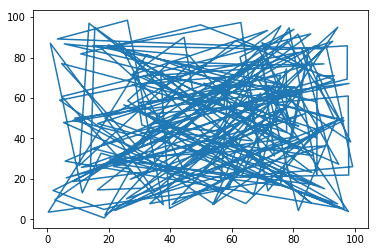

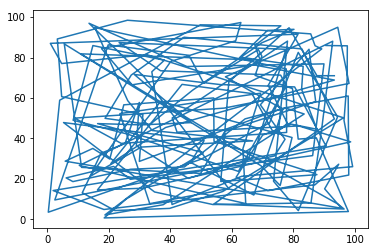

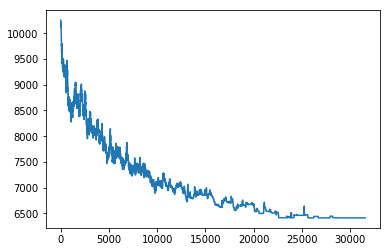

In [440]:
i_x, i_y = TSP(cpoints, make_swap_neigh)
plt.plot(i_x, i_y)
plt.show()

W obu przypadkach widzimy, że sytuacja poprawiła się a koszt zmniejszył się prawie dwukrotnie. Na wykresie zmiany energii w kolejnych krokach można zauważyć skoki energii, które zmiejszają się wraz z kolejnymi krokami. Jest to zgodne z ideą działania algorytmu. W obu przypadkach wybrane drogi uprościły się co widać na wykresach. Nie jest to optymalne rozwiązanie, ale lepsze od wcześniejszego.  
Można również zauważyć, że zmiany dowolnych dwóch wierzchołków dały lepsze efekty i lepsze wynik niż zmiany tylko sąsiednich. Wynika to prawdopodobnie z faktu, że jest mniejsza ilośc możliwych zamian i żeby doprowadzić do analogicznego stanu jak zamiana dowolnych potrzeba więcej ruchów.

Przeanalizujmy teraz działanie algorytmu dla grup punktów.

In [472]:
def generate_groups(m = 4):
    p = int(math.sqrt(m))
    w = 1000 / p
    s_points = np.array([(0,0)])
    for i in range(m):
        points = np.array(generate_random_points(100, 100))
        points = np.array(list(map(lambda x: (x[0] + i%p * w, x[1] + i/p * w), points)))
        s_points = np.concatenate((s_points, points))
    np.random.shuffle(s_points)
    return s_points

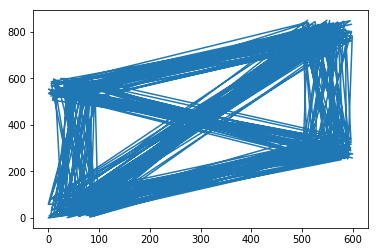

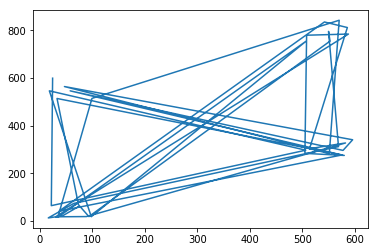

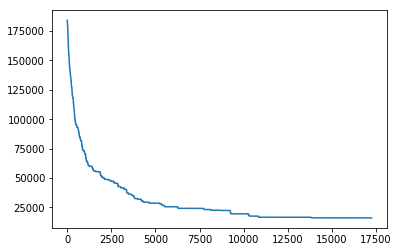

In [473]:
i_x, i_y = TSP(generate_groups(), make_swap_neigh)
plt.plot(i_x, i_y)
plt.show()

Widzimy, że trasa znacząco się uprościła nie tylko pomiędzy grupami ale także wewnątrz. Obserwując wykres zmian energii możemy dojść do wniosku, że pierwsze zostały zredukowane trasy między grupami (zmiany były bardzo duże) natomiast od pewnego momentu wewnątrz grup.

Algorytm symulowanego wyżarzania sprawdził się dla problemu komiwojażera. Potrafił on znacząco zredukować koszt odwiedzenia miast. Nie jest to rozwiązanie optymalne jednak prostym algorytmem możemy uzyskać duży spadek energii.  Na pewno nie jedna firma kuriersk byłaby zadowolona z tak dużych oszczędności.

# Binary Images

W tym zadaniu zajmiemy się generowaniem obrazków binarnych dla różnych funkcji energii. Zaczynamy od losowego ustawienia czarnych punktów na planszy, a następnie minimalizujemy energię za pomocą symulowanego wyżarzania. Na początek definiujemy funkcje pomocnicze, tworzące i wyświetlające obrazek.

In [523]:
def random_image(w,h,p=0.3):
    img = np.array([0 if random.random() > p else 1 for i in range(w*h)])
    return np.reshape(img, (w, h))

In [532]:
def show_image(img, name=None):
    imgplot = plt.imshow(img, cmap = mpl.cm.Greys)
    if name != None:
        plt.savefig('binary_images/'+name+'.png')
    plt.show()

In [533]:
def show_anim(anim, name=None):
    fig = plt.figure()
    ims = []
    for img in anim:
        im = plt.imshow(img, cmap = mpl.cm.Greys, animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=False,repeat_delay=10000)
    if name != None:
        ani.save('binary_images/'+name+'.mp4')
    plt.close()
    display(HTML(ani.to_html5_video()))

Kroki będziemy wykonywać zamieniając dwa losowe punkty ze sobą. Definiujemy także funkcję odwrotną do kroku.

In [503]:
def make_img_swap(img):
    w,h = np.shape(img)
    i1 = random.randint(0,w - 1)
    j1 = random.randint(0,h - 1)
    i2 = random.randint(0,w - 1)
    j2 = random.randint(0,h - 1)
    img[i1][j1], img[i2][j2] = img[i2][j2], img[i1][j1]
    return i1, j1, i2, j2

In [504]:
def make_img_back_swap(img, i1, j1, i2, j2):
    img[i1][j1], img[i2][j2] = img[i2][j2], img[i1][j1]

In [537]:
def generate(E, p=0.2, name = "default"):
    img = random_image(100,100,p)
    show_image(img)
    res_img, i_x, i_y, anim = simulated_annealing(img, E, make_img_swap, make_img_back_swap, s_p = 0.5, p=0.995, iters=10000, anim_step=100)
    show_image(res_img, name)
    show_anim(anim, name)
    #plt.plot(i_x, i_y)
    #plt.show()

## Środek

Pierwsza z funkcji energii stara się skupić czarne kropki wokół wybranego punktu w obrazku. Oczekujemy, że punkty będą tworzyć okrąg wokół wybranego punktu (30, 30).

In [538]:
def E_center(img):
    sum = 0
    w, h = np.shape(img)
    for i in range(1,w-1):
        for j in range(1,h-1):
            sum += img[i][j]*(abs(30-i)**2 + abs(30-j)**2)
    return sum

Sprawdzamy funkcję dla dwóch gęstości prawdopodobieństwa początkowego.

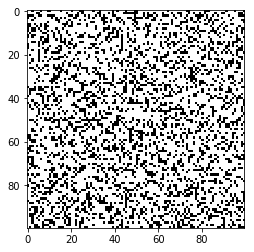

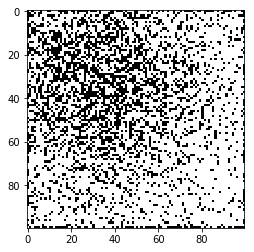

In [540]:
generate(E_center, p=0.3, name="center03")

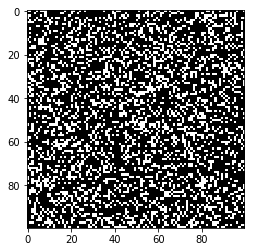

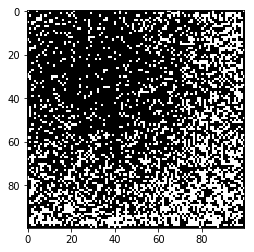

In [541]:
generate(E_center, p=0.7, name="center07")

## Wyspy

W następnej funkcji staramy się aby funkcja była minimalna gdy czarne są jak najbliżej siebie. Dla zadanego punktu definiujemy ją jako -2^s gdzie s to ilość czarnych sąsiadów. Drugą potęga pozwala nam nagradzać funkcję znacząco gdy ma więcej punktów blisko siebie. Oczekujemy, że powtorzą się wyspy punktów.

In [542]:
def E_island(img):
    sum = 0
    w, h = np.shape(img)
    for i in range(1,w-1):
        for j in range(1,h-1):
            sum += img[i][j]*(2**(img[i-1][j] + img[i][j-1] + img[i+1][j] + img[i][j+1]))
    return -sum

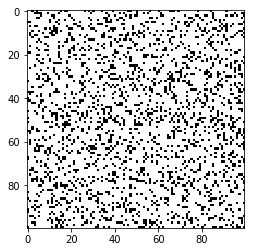

In [ ]:
generate(E_island, name="island")

## Szachownica

Następna funkcja jest podobna do poprzedniej z tą różnicą, że zamiast czarnego punktu w środku najlepszy jest punkt biały. Oczekujemy, że stworzy się szachownica.

In [ ]:
def E_chess(img):
    sum = 0
    w, h = np.shape(img)
    for i in range(1,w-1):
        for j in range(1,h-1):
            sum += (1 - img[i][j])*(2**(img[i-1][j] + img[i][j-1] + img[i+1][j] + img[i][j+1]))
    return -sum

In [ ]:
generate(E_chess, p=0.5)

## Linie

Kolejna funkcja ma najmniejszą energię gdy czarny punkt ma inne czarne punkty nad lub pod sobą, natomiast zwiększa się gdy punkty są obok. Oczekujemy że stworzą się na przemian czarne i białe linie.

In [ ]:
def E_lines(img):
    sum = 0
    w, h = np.shape(img)
    for i in range(1,w-1):
        for j in range(1,h-1):
            sum += img[i][j]*(2**(img[i-1][j] + img[i+1][j]) - img[i][j-1] - img[i][j+1])
    return -sum

In [ ]:
generate(E_lines, p=0.5)

## Trójkąty

Ostatnia z funkcji również bazuje na współczynniku 2^, jednak tym razem "lubi" ona czarne punkty znajdujące się po prawej lub na górze. Oczekujemy, że powstanie coś na kształt trójkątów.

In [ ]:
def E_triangles(img):
    sum = 0
    w, h = np.shape(img)
    for i in range(1,w-1):
        for j in range(1,h-1):
            sum += img[i][j]*(2**(img[i-1][j] + img[i-1][j-1]) + img[i][j-1])
    return -sum

In [ ]:
generate(E_triangles, p=0.5)

# Sudoku

Na koniec sprawdzimy algorytm symulowanego wyżarzania do rozwiązywania plansz sudoku. Zbiór plansz pochodzi ze strony https://www.kaggle.com/bryanpark/sudoku. Podobnie jak wcześniej na początku definiujemy funkcje pomocnicze. Zakładamy, że na początku plansza jest wypełniona odpowiednią ilością każdej z cyfr (ale nie na swoich pozycjach).

In [3]:
qs = np.load('sudokus/sudoku_quizzes.npy')[:52]

In [196]:
def init(S):
    #cS = [a if a != 0 else random.randint(1,9) for a in np.reshape(S, -1)]
    #return np.reshape(cS, S.shape)
    _, was = np.unique(S, return_counts=True)
    was = 9 - was
    cS = deepcopy(S)
    c = 1
    is_static = np.zeros(S.shape)
    for i in range(len(cS)):
        for j in range(len(cS[i])):
            while c < len(was) and was[c] == 0:
                c += 1
            if cS[i][j] == 0:
                cS[i][j] = c
                was[c] -= 1
            else:
                is_static[i][j] = 1
    return cS, is_static

Funkcję energii definijemy jako sumę iloczynów danej liczby i jej wystąpień poza oczekiwaną wartość (1) w każdym wierszu, kolumnie i kwadracie.

In [391]:
def check(S):
    val, was = np.unique(S, return_counts=True)
    err = 0
    for i in range(len(was)):
        err += abs(1-was[i])*val[i]
    return err

In [389]:
def E(S):
    e = 0
    for i in range(len(S)):
        e += check(S[i])
        e += check(S[:,i])
        
    for i in range(0,len(S),3):
        for j in range(0,len(S[i]),3):
            e += check(np.reshape(S[i:i+3,j:j+3],-1))
            
    return e

Definiujemy dwie funkcje wykonujące kolejny ruch. Pierwsza zamienia ze sobą liczby na dowolnych polach (korzystając z tego, że jest już odpowiednia ilość cyfr na planszy). Druga natomiast wybiera koórkę i wpisuje do niech losową wartość od 1 do 9. W praktyce używamy tylko pierwszej, ponieważ lepiej współgra z definicją energii.

In [316]:
def get_swaps(S, is_static):
    def make_sudoku_swap(S):
        w, h = S.shape
        i1 = random.randint(0,w - 1)
        j1 = random.randint(0,h - 1)
        i2 = random.randint(0,w - 1)
        j2 = random.randint(0,h - 1)
        if is_static[i1][j1] == 0 and is_static[i2][j2] == 0: 
            S[i1][j1], S[i2][j2] = S[i2][j2], S[i1][j1]
            return i1, j1, i2, j2
        else:
            return i1, j1, i1, j1
    
    def make_sudoku_back_swap(S, i1, j1, i2, j2):
        S[i1][j1], S[i2][j2] = S[i2][j2], S[i1][j1]
    
    return make_sudoku_swap, make_sudoku_back_swap

In [317]:
def get_single_changes(S, is_static):
    def make_sudoku_swap(S):
        w, h = S.shape
        i1 = random.randint(0,w - 1)
        j1 = random.randint(0,h - 1)
        prev = S[i1][j1]
        if is_static[i1][j1] == 0: 
            S[i1][j1] = random.randint(1,9)
        return i1, j1, prev
    
    def make_sudoku_back_swap(S, i1, j1, val):
        S[i1][j1] = val
    
    return make_sudoku_swap, make_sudoku_back_swap

Celem jest całkowite rozwiązanie sudoku więc dążymy do energii równej 0. Aby to osiągnać powtarzamy wyżarzanie od ostatniego stanu na jakim skończyliśmy. Pozwola to wyjśc do stanów o wyższej energii, aby uniknąc utknięcia w minimum lokalnym.

In [394]:
def solve(q):
    S, is_static = init(q)
    iter = 1
    best = deepcopy(S)
    cS = deepcopy(S)
    s_x = [0]
    s_y = [E(S)]
    last = E(S)
    lastc = 0
    after_new = True
    while E(best) != 0 and iter < 30:
        S, i_x, i_y, _ = simulated_annealing(S, E, *get_swaps(S, is_static), 
                                             s_p=0.25 if after_new else 0.005, p=0.9998, iters=30000)
        after_new = False
        i_x = list(map(lambda x: x + s_x[-1], i_x))
        s_x += i_x
        s_y += i_y
        if E(S) < E(best):
            best = deepcopy(S)
            
        if last == E(S):
            lastc += 1
        else:
            lastc = 0
        
        if lastc >= 5:
            S = deepcopy(cS)
            after_new = True
            
        print("Iteration ",iter, " completed, result: ", E(S))
        print(S)
        plt.plot(s_x, s_y)
        plt.show()
        iter += 1
    print("It took ", iter - 1)
    return best, s_x, s_y    

Iteration  1  completed, result:  22
[[9 4 6 1 7 2 3 5 8]
 [1 8 7 5 4 3 9 6 2]
 [5 2 3 6 9 8 1 7 4]
 [5 6 9 8 3 2 4 1 7]
 [4 7 2 9 1 6 8 3 5]
 [8 1 3 7 5 4 6 2 9]
 [7 9 8 2 6 1 5 4 3]
 [6 3 1 4 8 5 7 9 2]
 [2 5 4 3 9 7 1 8 6]]


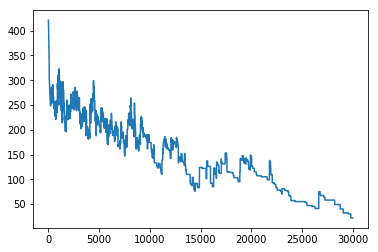

Iteration  2  completed, result:  8
[[3 4 6 1 7 9 3 5 8]
 [1 8 7 5 4 3 9 6 2]
 [5 2 9 6 2 8 1 7 4]
 [9 6 5 8 3 2 4 1 7]
 [4 7 2 9 1 6 8 3 5]
 [8 1 3 7 5 4 6 2 9]
 [7 9 8 2 6 1 5 4 3]
 [6 3 1 4 8 5 7 9 2]
 [2 5 4 3 9 7 1 8 6]]


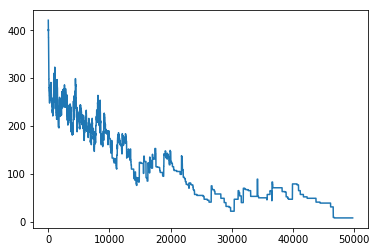

Iteration  3  completed, result:  6
[[3 4 6 1 7 9 1 5 8]
 [1 8 7 5 4 3 9 6 2]
 [5 2 9 6 2 8 3 7 4]
 [9 6 5 8 3 2 4 1 7]
 [4 7 2 9 1 6 8 3 5]
 [8 1 3 7 5 4 6 2 9]
 [7 9 8 2 6 1 5 4 3]
 [6 3 1 4 8 5 7 9 2]
 [2 5 4 3 9 7 1 8 6]]


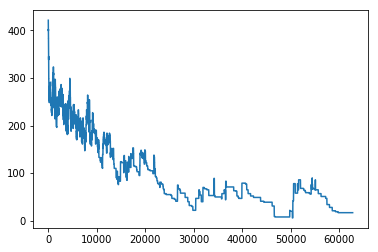

Iteration  4  completed, result:  3
[[3 4 6 1 7 9 2 5 8]
 [1 8 7 5 4 3 9 6 1]
 [5 2 9 6 2 8 3 7 4]
 [9 6 5 8 3 2 4 1 7]
 [4 7 2 9 1 6 8 3 5]
 [8 1 3 7 5 4 6 2 9]
 [7 9 8 2 6 1 5 4 3]
 [6 3 1 4 8 5 7 9 2]
 [2 5 4 3 9 7 1 8 6]]


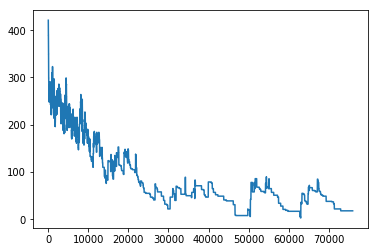

Iteration  5  completed, result:  3
[[3 4 6 1 7 9 2 5 8]
 [1 8 7 5 4 3 9 6 1]
 [5 2 9 6 2 8 3 7 4]
 [9 6 5 8 3 2 4 1 7]
 [4 7 2 9 1 6 8 3 5]
 [8 1 3 7 5 4 6 2 9]
 [7 9 8 2 6 1 5 4 3]
 [6 3 1 4 8 5 7 9 2]
 [2 5 4 3 9 7 1 8 6]]


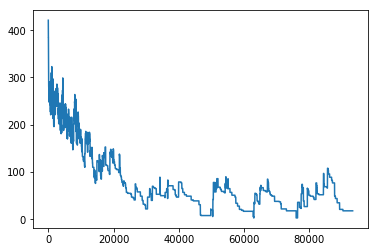

Iteration  6  completed, result:  0
[[3 4 6 1 7 9 2 5 8]
 [1 8 7 5 2 3 9 6 4]
 [5 2 9 6 4 8 3 7 1]
 [9 6 5 8 3 2 4 1 7]
 [4 7 2 9 1 6 8 3 5]
 [8 1 3 7 5 4 6 2 9]
 [7 9 8 2 6 1 5 4 3]
 [6 3 1 4 8 5 7 9 2]
 [2 5 4 3 9 7 1 8 6]]


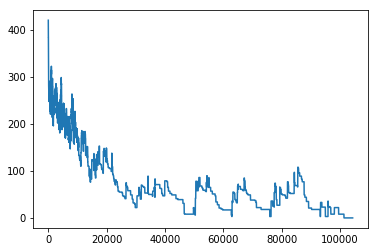

It took  7


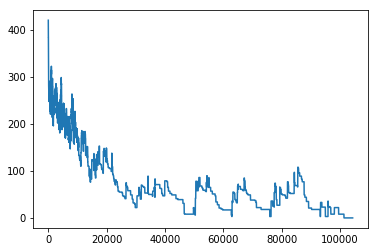

In [397]:
S, i_x, i_y = solve(qs[1])
plt.plot(i_x, i_y)
plt.show()

Algorytm działa i dochodzi do energii 0 w każdym przypadku. Nie jest to jednak optymalne i w praktyce potrzeba wielu powtórzeń i rozpoczęć od nowa (około 7-10) aby to osiągnąć. Algorytm szybko schodzi do stanów o energii około 10, jednak bardzo często okazują się one minimami lokalnymi i potem potrzebnych jest wiele iteracji, aby z nich wyjść.